# Dynamic Programming Exercises

## Exercise 1


### 1. State variables:

Stock of oil $s_t$ and price $p_t$.

### 2. Control variables:

Amount of oil to sell $x_t$.

### 3. Transition equation:

$s_{t+1} = s_t - x_t$.

### 4. Problem

The sequence problem is:

$\underset{\{x_t\}_{t\in\mathbb N}}{\max}
\left\{\sum_{t\in\mathbb Z} 
\left(\frac{1}{1+r}\right)^tp_t x_t \right\}$

subject to: $s_0 = B$, $s_{t+1} = s_t - x_t$ and $x_t \ge 0$ for all $t$.

The Bellman equation is of the form:

$V(s) = \max_x\left\{px + \frac{1}{1+r} V(s - x)\right\}$.

### 5. The Euler equation

$p_t = p_{t+1}\frac{1}{1+r}$

### 6. The solution

Since the utility function is linear, the solution is piecewise.

If $p_{t+1} = p_t$ for all t, then we sell everything today: $x_0 = B$. This follows from the fact that we get the same absolute payoff from selling a marginal unit in any period, but we discount the future.

If $p_{t+1} > (1+r)p_t$, then $x_t = 0$ for all $t$. 
This is actually a violation of the transversality condition, and so the model is not stationary in this case.

A necessary condition for an interior solution is $p_t(1+r) = p_{t+1}$


## Exercise 2

### 1. State variables:

Amount of capital $k_t$ and shock to production $z_t$.

### 2. Control variables:

Consumption $c_t$.

### 3. Bellman Equation:

$V(z_t, k_t) = \max_c\{U(c_{t}) + \beta\mathbb EV(z_{t+1}, k_{t+1})\}$

subject to:

$k_{t+1} + c_t = z_t k_t^\alpha + (1-\delta)k_t$



#### Import some packages

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import ar1_approx as ar1

# to print plots inline
%matplotlib inline

### Set Parameters

Parameters:
* $\gamma$ : Coefficient of Relative Risk Aversion
* $\beta$ : Discount factor
* $\delta$ : Rate of depreciation
* $\alpha$ : Curvature of production function
* $\sigma_z$ : Standard dev of productivity shocks


In [2]:
gamma = 0.5
beta  = 0.96
delta = 0.05
alpha = 0.4
sigma = 0.2
mu    = 0
rho   = 0

### Create Grid Space

In [4]:
'''
------------------------------------------------------------------------
Create Grid for State Space - Capital    
------------------------------------------------------------------------
lb_k      = scalar, lower bound of capital grid
ub_k      = scalar, upper bound of capital grid 
size_k    = integer, number of grid points in capital state space
k_grid    = vector, size_k x 1 vector of capital grid points 
------------------------------------------------------------------------
'''
lb_k   = 5 # Note that the steady state of k is 11.65 so we create grid around that
ub_k   = 15 
size_k = 50  # Number of grid points for k
k_grid = np.linspace(lb_k, ub_k, size_k)

'''
Create grid of shocks
'''
size_z = 50
ln_z_grid, pi_t = ar1.addacooper(size_z, mu, rho, sigma)
z_grid = np.exp(ln_z_grid)
pi = np.transpose(pi_t)

In [5]:
'''
------------------------------------------------------------------------------
Create grid of current utility values    
------------------------------------------------------------------------------
C        = matrix, current consumption (c=z_tk_t^alpha - k_t+1 + (1-delta)k_t)
U        = matrix, current period utility value for all possible
           choices of w and w' (rows are w, columns w')
------------------------------------------------------------------------------
'''

C = np.zeros((size_k, size_k, size_z)) 
for i in range(size_k): # loop over k
    for j in range(size_k): # loop over k'
        for t in range(size_z): # loop over z
            C[i, j, t] = z_grid[t]*k_grid[i]**alpha + (1 - delta)*k_grid[i] - k_grid[j] # note that if w'>w, consumption negative
# replace 0 and negative consumption with a tiny value 
# This is a way to impose non-negativity on cons
C[C<=0] = 1e-8
if gamma == 1:
    U = np.log(C)
else:
    U = (C ** (1 - gamma)) / (1 - gamma)
U[C<0] = -9999999

### Value function iteration

In [6]:
'''
------------------------------------------------------------------------
Value Function Iteration    
------------------------------------------------------------------------
VFtol     = scalar, tolerance required for value function to converge
VFdist    = scalar, distance between last two value functions
VFmaxiter = integer, maximum number of iterations for value function
V         = vector, the value functions at each iteration
Vmat      = matrix, the value for each possible combination of w and w'
Vstore    = matrix, stores V at each iteration 
VFiter    = integer, current iteration number
TV        = vector, the value function after applying the Bellman operator
PF        = vector, indicies of choices of w' for all w 
VF        = vector, the "true" value function
------------------------------------------------------------------------
'''

VFtol = 1e-6
VFdist = 7.0
VFmaxiter = 5000
V = np.zeros((size_k, size_z)) # initial guess at value function
Vmat = np.zeros((size_k, size_k, size_z))
Vstore = np.zeros((size_k, size_k, VFmaxiter)) # initialize Vstore array
VFiter = 1
while VFdist > VFtol and VFiter < VFmaxiter:
    for i in range(size_k): # loop over w
        for j in range(size_k): # loop over w'
            for k in range(size_z): # loop over z
                EV = 0
                for ii in range(size_z):
                    EV += pi[k, ii]*V[j, ii]
                Vmat[i, j, k] = U[i, j, k] + beta * EV
    Vstore[:, :, VFiter] = V.reshape(size_k, size_z,) # store value function at each iteration for graphing later
    TV = Vmat.max(1)
    PF = np.argmax(Vmat, axis=1)
    VFdist = (np.absolute(V - TV)).max()  # check distance
    V = TV
    VFiter += 1

if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')


VF = V # solution to the functional equation

Value function converged after this many iterations: 372


### Plot Value Function

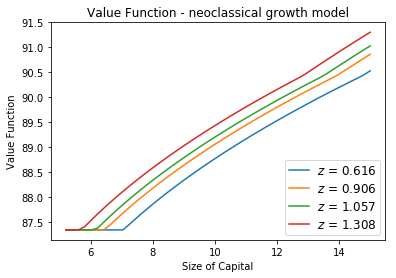

In [16]:
# Plot value function
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[1:], VF[1:, 0], label='$z$ = ' + str(round(z_grid[0], 3)))
ax.plot(k_grid[1:], VF[1:, 15], label='$z$ = ' + str(round(z_grid[15], 3)))
ax.plot(k_grid[1:], VF[1:, 30], label='$z$ = ' + str(round(z_grid[30], 3)))
ax.plot(k_grid[1:], VF[1:, 45], label='$z$ = ' + str(round(z_grid[45], 3)))
# Now add the legend with some customizations.
legend = ax.legend(loc='lower right', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital')
plt.ylabel('Value Function')
plt.title('Value Function - neoclassical growth model')
plt.show()


### Plot optimal consumption rule

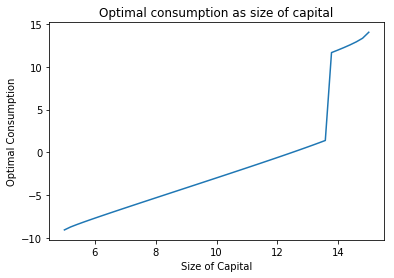

In [21]:
# Plot optimal consumption rule as a function of capital size
optK = k_grid[PF]
optC = z_grid * k_grid ** (alpha) + (1 - delta) * k_grid - optK
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[:], optC[:][4], label='Consumption')
# Now add the legend with some customizations.
#legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital')
plt.ylabel('Optimal Consumption')
plt.title('Optimal consumption as size of capital')
plt.show()


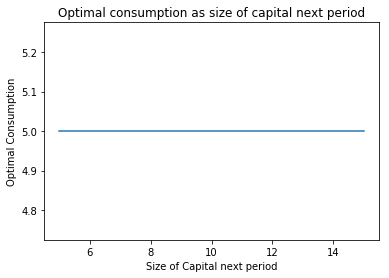

In [20]:
# Plot optimal consumption rule as a function of capital next period
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[:], optK[:][17], label='Consumption')
# Now add the legend with some customizations.
#legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital next period')
plt.ylabel('Optimal Consumption')
plt.title('Optimal consumption as size of capital next period')
plt.show()

## Question 3

### 1. Bellman equation

$$V(z_t, k_t) = Max_c\{U(C_{t}) + \beta E_tV(z_{t+1}, k_{t+1})\}$$


### Set Parameters

Parameters:
* $\gamma$ : Coefficient of Relative Risk Aversion
* $\beta$ : Discount factor
* $\delta$ : Rate of depreciation
* $\alpha$ : Curvature of production function
* $\sigma_z$ : Standard dev of productivity shocks


In [76]:
gamma = 0.5
beta  = 0.96
delta = 0.05
alpha = 0.4
sigma_v = 0.1
mu    = 0
rho   = 0.8

In [77]:
'''
------------------------------------------------------------------------
Create Grid for State Space - Capital    
------------------------------------------------------------------------
lb_k      = scalar, lower bound of capital grid
ub_k      = scalar, upper bound of capital grid 
size_k    = integer, number of grid points in capital state space
k_grid    = vector, size_k x 1 vector of capital grid points 
------------------------------------------------------------------------
'''
lb_k   = 5 #Note that the steady state of k is 11.65 so we create grid around that
ub_k   = 15 
size_k = 20  # Number of grid points for k
size_z = 20
k_grid = np.linspace(lb_k, ub_k, size_k)

In [78]:
'''
Create grid of shocks
'''
ln_z_grid, pi_t = ar1.addacooper(size_z, mu, rho, sigma_v)
z_grid = np.exp(ln_z_grid)
pi = np.transpose(pi_t)

In [79]:
'''
------------------------------------------------------------------------
Create grid of current utility values    
------------------------------------------------------------------------
C        = matrix, current consumption (c=z_tk_t^a - k_t+1 + (1-delta)k_t)
U        = matrix, current period utility value for all possible
           choices of w and w' (rows are w, columns w')
------------------------------------------------------------------------
'''

C = np.zeros((size_k, size_k, size_z)) 
for i in range(size_k): # loop over k
    for j in range(size_k): # loop over k'
        for t in range(size_z): # loop over z
            C[i, j, t] = z_grid[t]*k_grid[i]**alpha + (1 - delta)*k_grid[i] - k_grid[j] # note that if w'>w, consumption negative
# replace 0 and negative consumption with a tiny value 
# This is a way to impose non-negativity on cons
C[C<=0] = 1e-8
if gamma == 0.5:
    U = np.log(C)
else:
    U = (C ** (1 - sigma)) / (1 - sigma)
U[C<0] = -9999999

In [80]:
'''
------------------------------------------------------------------------
Value Function Iteration    
------------------------------------------------------------------------
VFtol     = scalar, tolerance required for value function to converge
VFdist    = scalar, distance between last two value functions
VFmaxiter = integer, maximum number of iterations for value function
V         = vector, the value functions at each iteration
Vmat      = matrix, the value for each possible combination of w and w'
Vstore    = matrix, stores V at each iteration 
VFiter    = integer, current iteration number
TV        = vector, the value function after applying the Bellman operator
PF        = vector, indicies of choices of w' for all w 
VF        = vector, the "true" value function
------------------------------------------------------------------------
'''

VFtol = 1e-6
VFdist = 7.0
VFmaxiter = 5000
V = np.zeros((size_k, size_z)) # initial guess at value function
Vmat = np.zeros((size_k, size_k, size_z))
Vstore = np.zeros((size_k, size_k, VFmaxiter)) # initialize Vstore array
VFiter = 1
while VFdist > VFtol and VFiter < VFmaxiter:
    for i in range(size_k): # loop over w
        for j in range(size_k): # loop over w'
            for k in range(size_z): # loop over z
                EV = 0
                for ii in range(size_z):
                    EV += pi[k, ii]*V[max(j - 1, 0), ii]
                Vmat[i, j, k] = U[i, j, k] + beta * EV
    Vstore[:, :, VFiter] = V.reshape(size_k, size_z,) # store value function at each iteration for graphing later
    TV = Vmat.max(1)
    PF = np.argmax(Vmat, axis=1)
    VFdist = (np.absolute(V - TV)).max()  # check distance
    V = TV
    VFiter += 1

if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')


VF = V # solution to the functional equation

Value function converged after this many iterations: 324


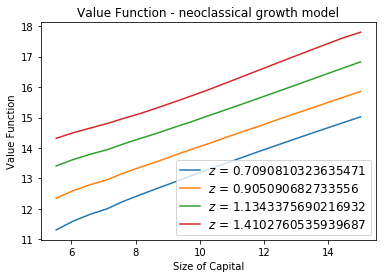

In [81]:
# Plot value function
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[1:], VF[1:, 0], label='$z$ = ' + str(z_grid[0]))
ax.plot(k_grid[1:], VF[1:, 5], label='$z$ = ' + str(z_grid[5]))
ax.plot(k_grid[1:], VF[1:, 15], label='$z$ = ' + str(z_grid[15]))
ax.plot(k_grid[1:], VF[1:, 19], label='$z$ = ' + str(z_grid[19]))
# Now add the legend with some customizations.
legend = ax.legend(loc='lower right', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital')
plt.ylabel('Value Function')
plt.title('Value Function - neoclassical growth model')
plt.show()


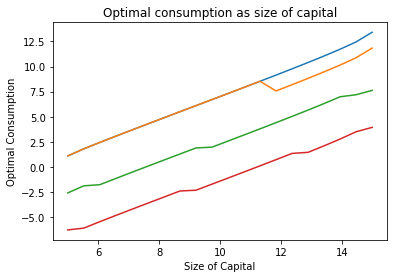

In [87]:
# Plot optimal consumption rule as a function of capital size
optK = k_grid[PF]
optC = z_grid * k_grid ** (alpha) + (1 - delta) * k_grid - optK
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[:], optC[:][0], label='Consumption')
ax.plot(k_grid[:], optC[:][4], label='Consumption')
ax.plot(k_grid[:], optC[:][10], label='Consumption')
ax.plot(k_grid[:], optC[:][17], label='Consumption')
# Now add the legend with some customizations.
#legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital')
plt.ylabel('Optimal Consumption')
plt.title('Optimal consumption as size of capital')
plt.show()

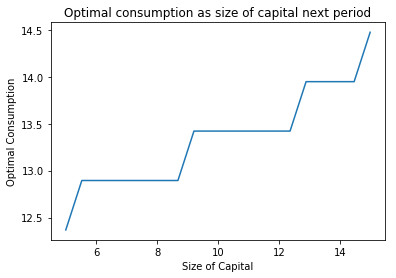

In [88]:
# Plot optimal consumption rule as a function of capital next period
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[:], optK[:][17], label='Consumption')
# Now add the legend with some customizations.
#legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital')
plt.ylabel('Optimal Consumption')
plt.title('Optimal consumption as size of capital next period')
plt.show()

## Question 4

### Bellman equation:
$V(w_t) = \max\left\{ V^U(w_t), V^J(w_t) \right\}$

where:
$V^U(w)=b+\beta EV(w')$

and
$V^J(w)=E_0\sum_{t=0}^\infty\beta^tw=\frac{w}{1-\beta}$

### Set Parameters

Parameters:
* $\gamma$ : Coefficient of Relative Risk Aversion
* $\beta$ : Discount factor
* $\delta$ : Rate of depreciation
* $\alpha$ : Curvature of production function
* $\sigma_z$ : Standard dev of productivity shocks

In [118]:
beta  = 0.96
b     = np.linspace(0.05,1,0.005)
size_b = len(b)
mu    = 0
sigma = 0.15
rho   = 0

In [119]:
size_w = 10
'''
Create grid of wage shocks
'''
import ar1_approx as ar1
ln_w_grid, pi_t = ar1.addacooper(size_w, mu, rho, sigma)
w_grid = np.exp(ln_w_grid)
pi = np.transpose(pi_t)
U = w_grid / (1-beta)

In [120]:
w_grid

array([0.76855166, 0.85496446, 0.90339441, 0.94367365, 0.98127786,
       1.01907935, 1.05968837, 1.10693622, 1.16963927, 1.30114871])

In [121]:
'''
------------------------------------------------------------------------
Value Function Iteration    
------------------------------------------------------------------------
VFtol       = scalar, tolerance required for value function to converge
VFdist      = scalar, distance between last two value functions
VFmaxiter   = integer, maximum number of iterations for value function
V           = matrix, the value functions at each iteration
TV          = matrix, the value function after applying the Bellman operator
PF_discrete = matrix, matrix of policy function: eat=1, not eat=0 
Vstore      = array, stores V at each iteration 
VFiter      = integer, current iteration number
EV          = scalar, expected value function for a given state
U_eat       = matrix, utility from eating cake now
Vwait       = matrix, value of waiting to eat the cake
VF          = vector, the "true" value function
------------------------------------------------------------------------
'''
VFtol = 1e-8 
VFdist = 7.0 
VFmaxiter = 3000 
V = np.zeros(size_w, size_b) # initial guess at value function
TV = np.zeros(size_w, size_b)
PF_discrete = np.zeros(size_w, size_b)
Vstore = np.zeros((size_w, size_b, VFmaxiter)) #initialize Vstore array
VFiter = 1 
while VFdist > VFtol and VFiter < VFmaxiter:
    for i in range(size_w): # loop over w
        EV = 0
        for ii in range(size_w):  # loop over w
            EV += pi[i, ii] * V[ii]   # note can move one space because of how we constructed grid
        U_job = U[i]
        for j in range(size_b):
            Vwait = b[j] + beta * EV 
            TV[i, j] = max(U_job, Vwait)
            PF_discrete[i, j] = U_job >= Vwait  
            
    Vstore[:,:, VFiter] = TV # store value function at each iteration for graphing later 
    VFdist = (np.absolute(V - TV)).max(0)  # check distance
    V = TV
    VFiter += 1 

if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')            


VF = V # solution to the functional equation

Value function converged after this many iterations: 3


In [122]:
'''
------------------------------------------------------------------------
Find threshold policy functions   
------------------------------------------------------------------------
'''
threshold_w = w_grid[np.argmax(PF_discrete, axis=0)]

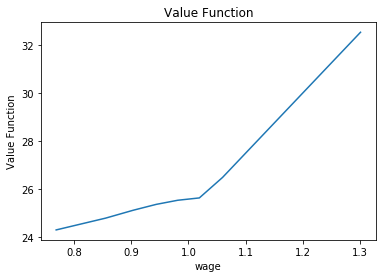

In [127]:
# Plot value function 
plt.figure()
fig, ax = plt.subplots()
ax.plot(w_grid[:], VF[:])
# Now add the legend with some customizations.
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('wage')
plt.ylabel('Value Function')
plt.title('Value Function')
plt.show()